# Preliminary analysis on  Split-CIFAR10

The purpose of this notebook is to perform preliminary analysis to the DER++ implementation with SplitCIFAR10, reproducing the paper experiments.

Evaluation is performed directly on the test set,  as we use the paper best found hyperparameters.

5 experiences of 2 classes each are used.

## Imports

In [43]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch

from torchvision.transforms import Compose, Normalize, ToTensor

from avalanche.benchmarks.classic import SplitCIFAR10


## Dataset

Following the DER paper, 5 experiences  were used, each with 2 new classes.

We are in a Class-Incremental setting, without task labels.

In [2]:
num_experiences = 5

In [3]:
# No transformations as they are applied in the DER plugin
split_cifar10 = SplitCIFAR10(n_experiences=num_experiences, seed=42, train_transform=Compose([ToTensor(), Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))]))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(len(split_cifar10.train_stream[0].dataset))
print(len(split_cifar10.test_stream[0].dataset))

10000
2000


In [5]:
# With transformations for Naive and Replay training
split_cifar10_transform = SplitCIFAR10(n_experiences=num_experiences, seed=42)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(len(split_cifar10_transform.train_stream[0].dataset))
print(len(split_cifar10_transform.test_stream[0].dataset))

10000
2000


### Show some samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


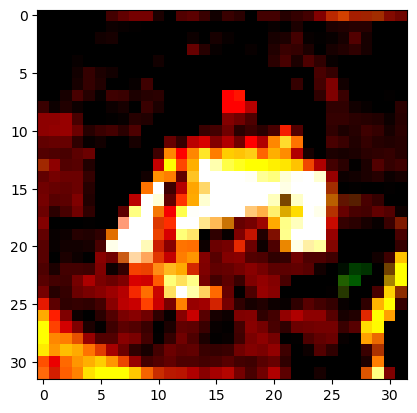

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


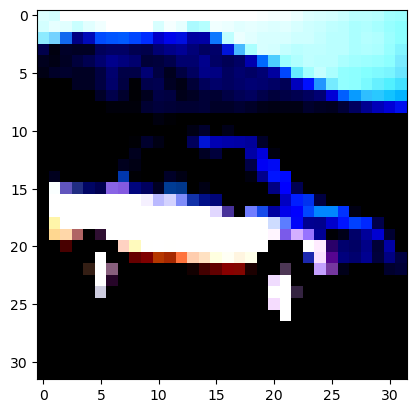

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


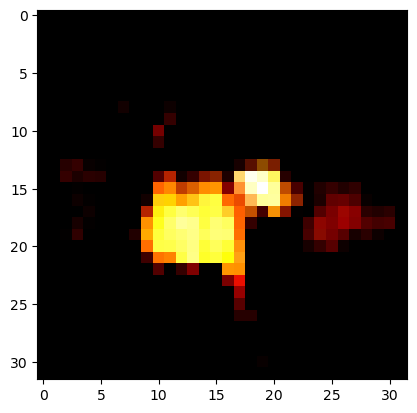

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


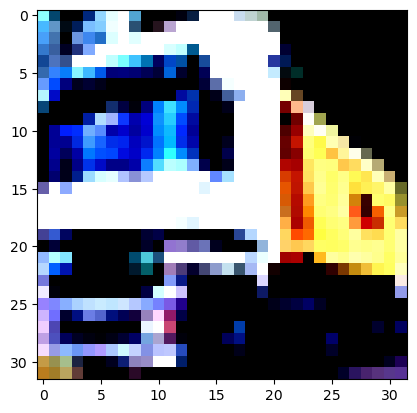

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


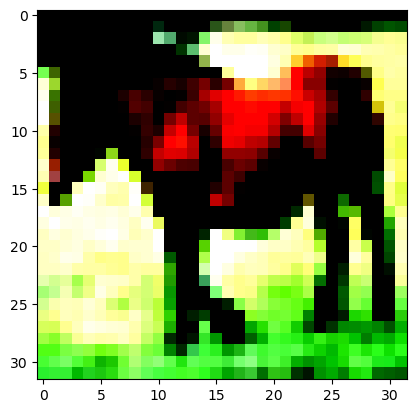

In [7]:
for experience in split_cifar10.train_stream:
    # Show the first image for each experience
    for sample in experience.dataset:
        plt.imshow(sample[0].permute(1, 2, 0))
        plt.show()
        break

# Train

In [8]:
from torchvision.models import resnet18
from torch.nn import CrossEntropyLoss
from avalanche.training import Naive

In [9]:
if torch.cuda.is_available():       
        device = torch.device("cuda")
        print(f'There are {torch.cuda.device_count()} GPU(s) available.')
        print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [10]:
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics, bwt_metrics
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger

In [11]:
save_folder = './results/SCIFAR10'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

## DER++

In [12]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(trained_experience=True, stream=True, epoch_running=True),
    loss_metrics(stream=True, epoch_running=True, epoch=True),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger(),
                TextLogger(open(os.path.join(save_folder, 'exploratory_SCIFAR10_der.txt'), 'a')),
                TensorboardLogger(os.path.join(save_folder, 'der_tb'))
              ],
)

In [13]:
from der import DerPlugin

Choose best hyperparams from DER paper. We use a buffer size of 500.

In [14]:
lr = 0.03
buffer_size = 500
alpha = 0.2
beta = 0.5
epochs = 50

In [15]:
model = resnet18(weights=None, num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()

der_plugin = DerPlugin(mem_size=buffer_size, alpha=alpha, beta=beta)

cl_strategy = Naive(model, optimizer, criterion, train_mb_size=64, train_epochs=epochs, eval_mb_size=64,
                    eval_every=0, device=device, evaluator=eval_plugin, plugins=[der_plugin])

Training loop

In [16]:
exp_results = []

In [17]:
# TRAINING LOOP WITH EVALUATION AT EACH EXPERIENCE

print('Starting experiment...')
results = []
for experience in split_cifar10.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    cl_strategy.train(experience)
    print('Training completed')

    exp_results.append(cl_strategy.eval(split_cifar10.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [2, 6]


-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 157/157 [00:04<00:00, 33.29it/s]
> Eval on experience 0 (Task 0) from train stream ended.
-- >> End of eval phase << --
	Accuracy_On_Trained_Experiences/eval_phase/train_stream/Task000 = 0.0000
	Loss_Stream/eval_phase/train_stream/Task000 = 2.3523
	StreamBWT/eval_phase/train_stream = 0.0000
	StreamForgetting/eval_phase/train_stream = 0.0000
	Top1_Acc_Stream/eval_phase/train_stream/Task000 = 0.0000
100%|██████████| 157/157 [00:03<00:00, 43.65it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.5909
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 1.5909
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.7150
100%|██████████| 157/157 [00:03<00:00, 48.46it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.7646
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.7646
	Top1_RunningAcc_Epoch/tra

### Get the accuracy on current and previous experiences

In [18]:
aggregated_results = {}

for i, exp_dict in enumerate(exp_results):
   for metric_name, metric_value in exp_dict.items():
        if metric_name not in aggregated_results:
            aggregated_results[metric_name] = []
            aggregated_results[metric_name].append(metric_value)
        else:
            aggregated_results[metric_name].append(metric_value)

acc_stream_der = aggregated_results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
acc_trained_exps_der = aggregated_results['Accuracy_On_Trained_Experiences/eval_phase/test_stream/Task000']
loss_stream_der = aggregated_results['Loss_Stream/eval_phase/test_stream/Task000']

### Plot the training loss curve for each experience

In [46]:
with open(os.path.join(save_folder, 'exploratory_SCIFAR10_der.txt'), 'r') as f:
# In the log file find all the lines starting with "Loss_Epoch"
    lines = [line for line in f.readlines() if line.startswith('\tLoss_Epoch')]
    # Get the final loss at each line after the = sign
    epoch_losses_list = [float(line.split('=')[1]) for line in lines]
    
# Divide by experiences
exp_epoch_losses = [epoch_losses_list[i:i+epochs] for i in range(0, len(epoch_losses_list), epochs)]


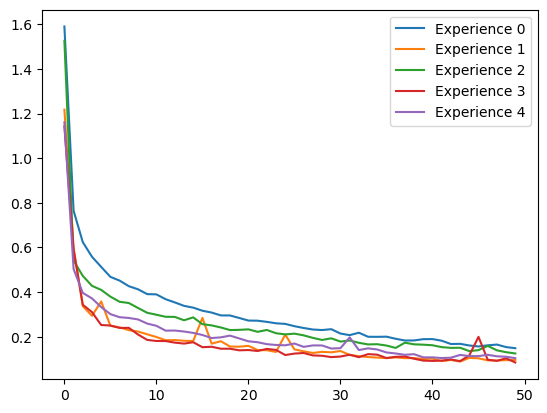

In [47]:
# Plot the loss for each experience
for i, exp_epoch_loss in enumerate(exp_epoch_losses):
    plt.plot(exp_epoch_loss, label=f'Experience {i}')
plt.xticks(range(0, epochs+1, 10))
plt.legend()
plt.show()

Plot the full loss curve across the experiences

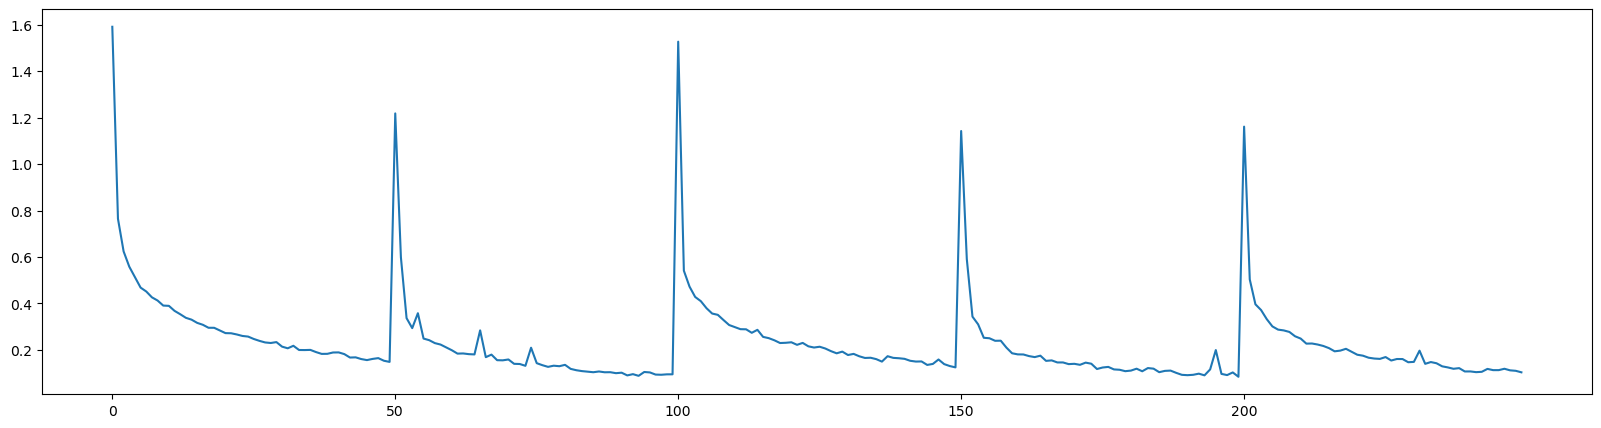

In [48]:
full_loss_stream = []
for i, exp_epoch_loss in enumerate(exp_epoch_losses):
    full_loss_stream += exp_epoch_loss

plt.plot(full_loss_stream)
plt.xticks(range(0, len(full_loss_stream), epochs))
plt.gcf().set_size_inches(20, 5)
plt.show()

### Check labels occurrences in the buffer are balanced

In [22]:
labels, occurrences = der_plugin.get_buffer_labels()
for label, occ in zip(labels, occurrences):
    print(f'Label: {label} - Occurrences: {occ}')

Label: 0 - Occurrences: 51
Label: 1 - Occurrences: 54
Label: 2 - Occurrences: 54
Label: 3 - Occurrences: 50
Label: 4 - Occurrences: 61
Label: 5 - Occurrences: 55
Label: 6 - Occurrences: 56
Label: 7 - Occurrences: 37
Label: 8 - Occurrences: 52
Label: 9 - Occurrences: 30


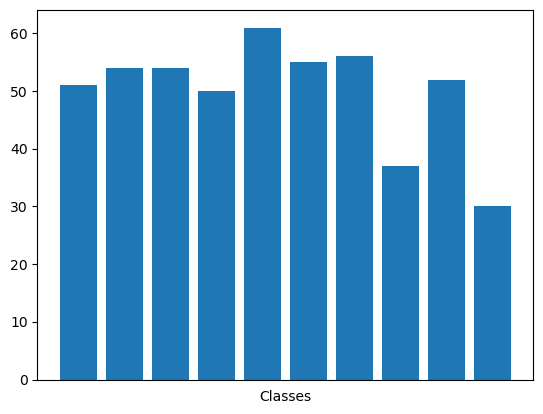

In [23]:
plt.bar(labels, occurrences)
plt.xlabel('Classes')
plt.xticks([])
plt.show()


# Replay

In [24]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(trained_experience=True, stream=True, epoch_running=True),
    loss_metrics(stream=True, epoch_running=True, epoch=True),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger(),
                TensorboardLogger(os.path.join(save_folder, 'replay_tb'))
              ],
)

In [25]:
from avalanche.training import Replay

In [26]:
lr = 0.1
buffer_size = 500
epochs = 50

In [27]:
model = resnet18(weights=None, num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()

cl_strategy = Replay(model, optimizer, criterion, mem_size=buffer_size, train_mb_size=64, train_epochs=epochs, eval_mb_size=64,
                    eval_every=0, device=device, evaluator=eval_plugin)

In [28]:
exp_results = []

In [29]:
# TRAINING LOOP WITH EVALUATION AT EACH EXPERIENCE

print('Starting experiment...')
results = []
for experience in split_cifar10_transform.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    cl_strategy.train(experience)
    print('Training completed')

    exp_results.append(cl_strategy.eval(split_cifar10_transform.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [2, 6]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
0it [00:00, ?it/s]

100%|██████████| 157/157 [00:02<00:00, 53.78it/s]
> Eval on experience 0 (Task 0) from train stream ended.
-- >> End of eval phase << --
	Accuracy_On_Trained_Experiences/eval_phase/train_stream/Task000 = 0.0000
	Loss_Stream/eval_phase/train_stream/Task000 = 2.4063
	StreamBWT/eval_phase/train_stream = 0.0000
	StreamForgetting/eval_phase/train_stream = 0.0000
	Top1_Acc_Stream/eval_phase/train_stream/Task000 = 0.0000
100%|██████████| 157/157 [00:03<00:00, 45.99it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.1118
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 1.1118
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.6475
100%|██████████| 157/157 [00:03<00:00, 46.15it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5323
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.5323
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.7764
100%|██████████| 157/157 [00:03<00:00, 42.06it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/tra

In [30]:
aggregated_results = {}

for i, exp_dict in enumerate(exp_results):
   for metric_name, metric_value in exp_dict.items():
        if metric_name not in aggregated_results:
            aggregated_results[metric_name] = []
            aggregated_results[metric_name].append(metric_value)
        else:
            aggregated_results[metric_name].append(metric_value)

acc_stream_er = aggregated_results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
acc_trained_exps_er = aggregated_results['Accuracy_On_Trained_Experiences/eval_phase/test_stream/Task000']
loss_stream_er = aggregated_results['Loss_Stream/eval_phase/test_stream/Task000']

# Naive

In [31]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(trained_experience=True, stream=True, epoch_running=True),
    loss_metrics(stream=True, epoch_running=True, epoch=True),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger(),
                TensorboardLogger(os.path.join(save_folder, 'naive_tb'))
              ],
)

In [32]:
lr = 0.1
epochs = 50

In [33]:
model = resnet18(weights=None, num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()

cl_strategy = Naive(model, optimizer, criterion, train_mb_size=64, train_epochs=epochs, eval_mb_size=64,
                    eval_every=0, device=device, evaluator=eval_plugin)

In [34]:
exp_results = []

In [35]:
# TRAINING LOOP WITH EVALUATION AT EACH EXPERIENCE

print('Starting experiment...')
results = []
for experience in split_cifar10_transform.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    cl_strategy.train(experience)
    print('Training completed')

    exp_results.append(cl_strategy.eval(split_cifar10_transform.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [2, 6]
-- >> Start of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
  1%|▏         | 2/157 [00:00<00:02, 62.82it/s]

100%|██████████| 157/157 [00:02<00:00, 60.50it/s]
> Eval on experience 0 (Task 0) from train stream ended.
-- >> End of eval phase << --
	Accuracy_On_Trained_Experiences/eval_phase/train_stream/Task000 = 0.0249
	Loss_Stream/eval_phase/train_stream/Task000 = 2.2649
	StreamBWT/eval_phase/train_stream = 0.0000
	StreamForgetting/eval_phase/train_stream = 0.0000
	Top1_Acc_Stream/eval_phase/train_stream/Task000 = 0.0249
100%|██████████| 157/157 [00:03<00:00, 52.24it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.9254
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.9254
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.6815
100%|██████████| 157/157 [00:03<00:00, 51.76it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5088
	RunningLoss_Epoch/train_phase/train_stream/Task000 = 0.5088
	Top1_RunningAcc_Epoch/train_phase/train_stream/Task000 = 0.7802
100%|██████████| 157/157 [00:03<00:00, 51.91it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/tra

In [36]:
aggregated_results = {}

for i, exp_dict in enumerate(exp_results):
   for metric_name, metric_value in exp_dict.items():
        if metric_name not in aggregated_results:
            aggregated_results[metric_name] = []
            aggregated_results[metric_name].append(metric_value)
        else:
            aggregated_results[metric_name].append(metric_value)

acc_stream_naive = aggregated_results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
acc_trained_exps_naive = aggregated_results['Accuracy_On_Trained_Experiences/eval_phase/test_stream/Task000']
loss_stream_naive = aggregated_results['Loss_Stream/eval_phase/test_stream/Task000']

# Compare DER++, ER and Naive on test stream

### Final average accuracy

In [40]:
print('DER++: ', acc_stream_der[-1])
print('Replay: ', acc_stream_er[-1])
print('Naive: ', acc_stream_naive[-1])

DER++:  0.5425
Replay:  0.459
Naive:  0.178


### Incremental average accuracy

In [45]:
print('DER++: ', np.mean(acc_trained_exps_der))
print('Replay: ', np.mean(acc_trained_exps_er))
print('Naive: ', np.mean(acc_trained_exps_naive))

DER++:  0.7008916666666667
Replay:  0.6843833333333333
Naive:  0.4284083333333334


### Plots over all experiences

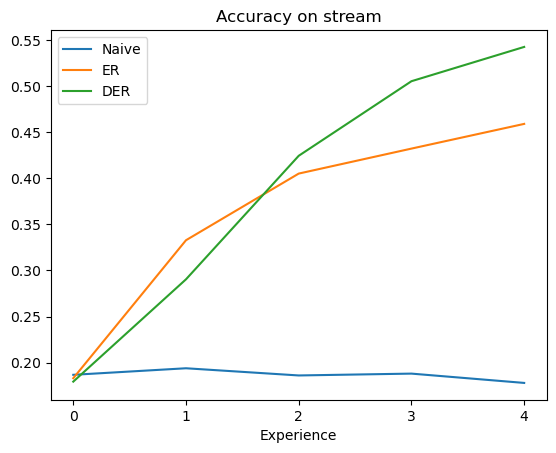

In [37]:
plt.plot(acc_stream_naive, label='Naive')
plt.plot(acc_stream_er, label='ER')
plt.plot(acc_stream_der, label='DER')
plt.xticks(range(len(acc_stream_naive)))
plt.xlabel('Experience')
plt.title('Accuracy on stream')
plt.legend()
plt.show()

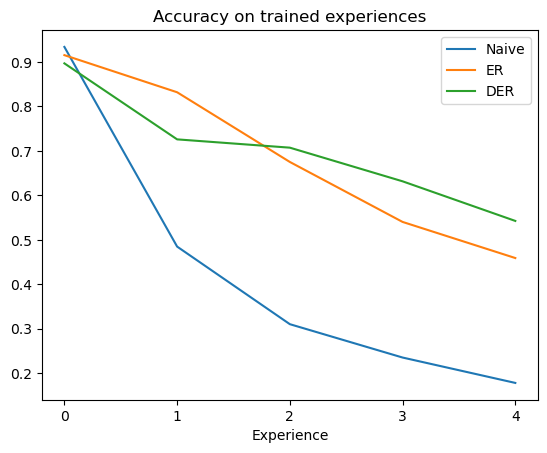

In [38]:
plt.plot(acc_trained_exps_naive, label='Naive')
plt.plot(acc_trained_exps_er, label='ER')
plt.plot(acc_trained_exps_der, label='DER')
plt.xticks(range(len(acc_stream_naive)))
plt.xlabel('Experience')
plt.title('Accuracy on trained experiences')
plt.legend()
plt.show()

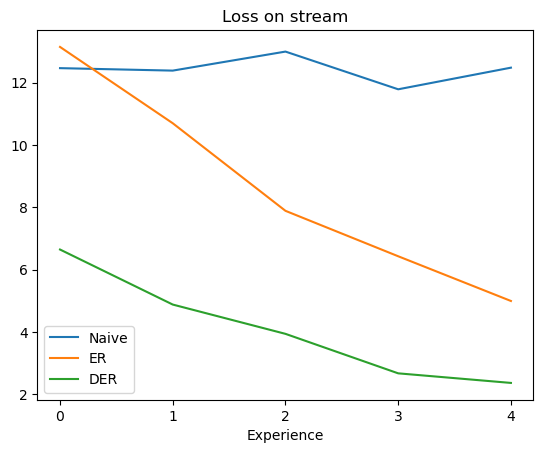

In [39]:
plt.plot(loss_stream_naive, label='Naive')  
plt.plot(loss_stream_er, label='ER')
plt.plot(loss_stream_der, label='DER')
plt.xticks(range(len(acc_stream_naive)))
plt.xlabel('Experience')
plt.title('Loss on stream')
plt.legend()
plt.show()